# A minimal working example

This notebook intends to showcase a minimal working example for using TranPyREnd with two radionuclides in a very simple model, containing only one geological layer. The required transport parameters are configured by hand.

## Import Python modules

In [1]:
import astropy.units as u
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

matplotlib.rcParams["font.size"] = 12

from transpyrend.core.externalsolver import DOP853TransportModel1D
from transpyrend.core.eulerbackwards import EulerBackwardsModel1D

## Set model parameters

### set grid spacing between nodes

In [2]:
dx = 1.0 * u.m

### total runtime and timestep size

In [3]:
total_runtime = 1e6 * u.year
dt = 100 * u.year

### respository location

In [4]:
repository_loc = 500.0 * u.m

### the parameters of the geological layer

The layer named 'unit' has a thickness of 1000 m and a porosity of 0.1. As we do not include advection in this example, we set the hydraulic properties to zero. To add a layer, simply add another dictionary to the list

In [5]:
parameters_rock = [{'name': "unit1", 
                    'thickness': 1000 * u.m,
                    'porosity': 0.1,  
                    'head_gradient': 0.0,
                    'hydraulic_conductivity': 0.*u.m/u.s
                    }]

### the radionuclides and their properties

This defines the transport parameters for the two radionuclides in 'unit1'.

In [6]:
nuclides = ["I-129", "Ca-41"]
parameters_transport_material = [{'I-129': 
                                  {'effective_diffusion_coefficient': 2.4e-12 * u.m**2 / u.s} ,
                                  'Ca-41': 
                                  {'effective_diffusion_coefficient': 1e-11 * u.m**2 / u.s},
                                }]

## Setup the model

Create the model with the parameters defined above.

In [7]:
model = EulerBackwardsModel1D(nuclides, 
                  parameters_rock, parameters_transport_material, 
                  geometry={"dx":dx},
                  time_interval=total_runtime)

## Get initial conditions

First, calculate the node index of the repository. Then, fill the initial conditions at the position of the repository with 1 mol/m$^3$ of both radionuclides.

In [8]:
repository_index = int(np.round(repository_loc / dx))

c0 = np.zeros(model.N)*u.mol/u.m**3
c0[repository_index] = 1.0*u.mol/u.m**3

ics = {"I-129":c0, "Ca-41":c0}

## Run the model

In [9]:
%time model.run(ics=ics, dt=dt)

Wall time: 9.62 s


## Analytical solution transient diffusion to compare results to:

Define a function to calculate the analytic solution for pure diffusion

In [10]:
def compare_diffusion(N, N0, dx,D, t_eval):
    nd = stats.norm.pdf#(x, mu, sigma)
    x = range(N)*dx
    mu = N0*dx
    res = np.zeros((x.size, t_eval.size))
    
    for i,t in enumerate(t_eval):
        if t == 0:
            continue
        sigma = np.sqrt(2*D.value*t)
        res[:,i] = nd(x, mu, sigma)   
    return res 


## Make a figure

Here, a comparison is shown with a pure diffusion solution for I-129. Since I-129 has a halflife of more than 10 million years, the pure diffusion solution matches relatively well.

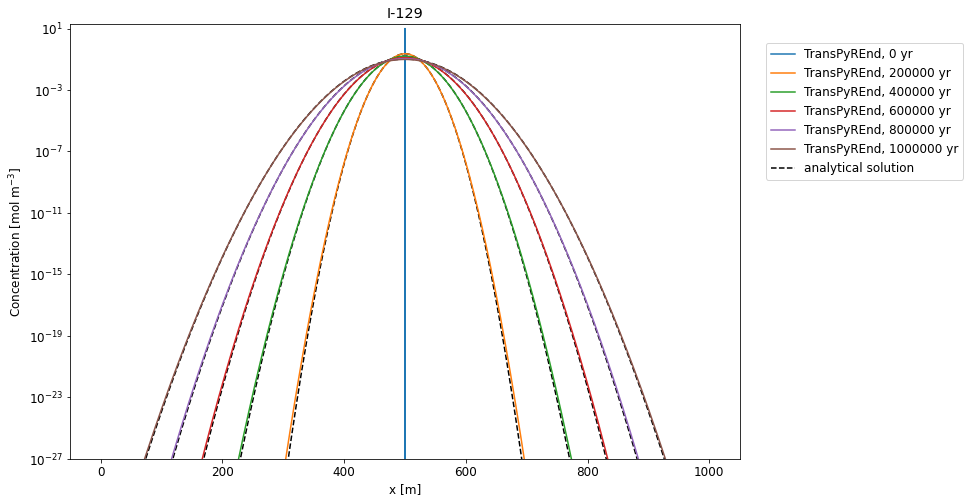

In [11]:
colors = [i for i in matplotlib.cm.get_cmap("tab10").colors]

t = model.results["t"].to(u.s)

nt = t.shape[0]

ts_plot = np.linspace(0, nt -1, 6).astype(int)

x0, c0 = model.get_concentrations_x("I-129", 0, quantity="molar density")
c_check = compare_diffusion(model.N, repository_index, 
                            model.dxs[1], 2.4e-12 * u.m**2 / u.s / 0.1, t) * c0.max()

plt.figure(figsize=(12,8))
ax = plt.gca()

for tsi, color in zip(ts_plot, colors):
    
    x, c = model.get_concentrations_x("I-129", tsi, quantity="molar density")
    label = f"TransPyREnd, {t[tsi].to(u.year):0.0f}"
    ax.plot(x, c, label=label)
    
    if tsi == ts_plot[-1]:
        ax.plot(model.x, c_check[:, tsi], ls="--", 
                label="analytical solution", color="k", zorder=-1)
    else:
        ax.plot(model.x, c_check[:, tsi], ls="--", color="k", zorder=-1)
    
ax.legend(loc="upper left", bbox_to_anchor=(1.03, 0.97))
ax.set_ylabel(r"Concentration [mol m$^{-3}$]")
ax.set_xlabel("x [m]")
ax.set_yscale("log")
ax.set_ylim(1e-27, c0.value.max() * 2)
plt.title("I-129")
plt.show()